# Fingerprint pair bit coverages

We investigate the bit coverage of the fingerprint pairs in the `kissim` dataset.

List the following numbers based on (a) all distances and (b) only distances matching a given bit coverage cutoff
- Number of structures
- Number of structure pairs (theory)
- Number of structure pairs (experimental)
- Number of kinases
- Number of kinase pairs (theory)
- Number of kinase pairs (experimental)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from kissim.comparison import FingerprintDistanceGenerator
from kissim.encoding import FingerprintGenerator

In [3]:
HERE = Path(_dh[-1])  # noqa: F821
RESULTS = HERE / "../../results/"

In [4]:
plt.style.use("seaborn")

In [5]:
%matplotlib inline

In [6]:
COVERAGE_CUTOFF = 0.75

## Load fingerprints

In [7]:
fingerprints = FingerprintGenerator.from_json(RESULTS / "fingerprints_clean.json")

In [8]:
fingerprint_bits = [
    fingerprint.values_array(True, True, True) for _, fingerprint in fingerprints.data.items()
]
fingerprint_bits = pd.DataFrame(fingerprint_bits)

In [9]:
fingerprint_bits.shape

(5222, 1032)

### Fingerprint bit coverage

In [10]:
fingerprint_coverage = 100 - fingerprint_bits.isna().sum(axis=1) / fingerprint_bits.shape[0] * 100
fingerprint_coverage = fingerprint_coverage.sort_values(ascending=False)
fingerprint_coverage.name = "Fingerprint coverage"

<AxesSubplot:>

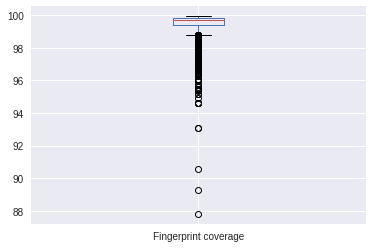

In [11]:
fingerprint_coverage.plot(kind="box")

In [12]:
fingerprint_coverage.describe()

count    5222.000000
mean       99.532203
std         0.614427
min        87.801609
25%        99.425507
50%        99.693604
75%        99.846802
max        99.942551
Name: Fingerprint coverage, dtype: float64

## Load fingerprint distances

In [13]:
fingerprint_distance_file = RESULTS / "fingerprint_distances.csv"

In [14]:
fingerprint_distance_generator = FingerprintDistanceGenerator.from_csv(fingerprint_distance_file)

In [15]:
print(f"Number of kinases: {len(fingerprint_distance_generator.kinase_ids)}")
print(f"Number of structures: {len(fingerprint_distance_generator.structure_ids)}")

Number of kinases: 292
Number of structures: 5222


In [16]:
structure_distances = fingerprint_distance_generator.data

### Sort fingerprint/kinase pairs (alphabetically)

In [17]:
%%time

structure_distances["structure_pair"] = (
    structure_distances[["structure.1", "structure.2"]].apply(list, axis=1).apply(sorted)
)
structure_distances["kinase_pair"] = (
    structure_distances[["kinase.1", "kinase.2"]].apply(list, axis=1).apply(sorted)
)

structure_distances["structure.1"] = [i[0] for i in structure_distances["structure_pair"]]
structure_distances["structure.2"] = [i[1] for i in structure_distances["structure_pair"]]
structure_distances["kinase.1"] = [i[0] for i in structure_distances["kinase_pair"]]
structure_distances["kinase.2"] = [i[1] for i in structure_distances["kinase_pair"]]
structure_distances = structure_distances.drop(["structure_pair", "kinase_pair"], axis=1)
structure_distances.head()

CPU times: user 3min 8s, sys: 3.15 s, total: 3min 11s
Wall time: 3min 11s


,structure.1,structure.2,kinase.1,kinase.2,distance,bit_coverage
0,3833,6679,AAK1,AAK1,0.051595,0.992667
1,3833,7156,AAK1,AAK1,0.057489,0.991333
2,1086,3833,AAK1,ABL1,0.271736,0.990667
3,1054,3833,AAK1,ABL1,0.290077,0.990667
4,1090,3833,AAK1,ABL1,0.266234,0.990667


## Fingerprint pair coverage

### Coverage between fingerprint pairs

In [18]:
COVERAGE_CUTOFF = 0.8

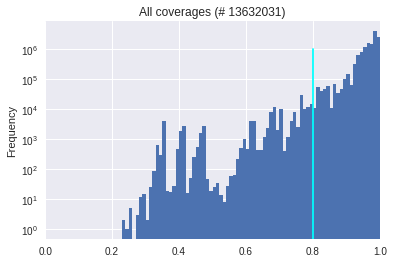

In [19]:
fig, ax = plt.subplots(1, 1)
structure_distances["bit_coverage"].plot(
    kind="hist",
    title=f"All coverages (# {structure_distances.shape[0]})",
    bins=np.arange(0, 1.05, 0.01),
    xlim=(0, 1),
    logy=True,
)
ax.plot([COVERAGE_CUTOFF, COVERAGE_CUTOFF], [0, 1000000], color="cyan")

We might want to filter out some fingerprint pairs because the coverage is super low.

In [20]:
structure_distances["bit_coverage"].describe()

count    1.363203e+07
mean     9.651623e-01
std      4.222376e-02
min      2.333333e-01
25%      9.560000e-01
50%      9.786667e-01
75%      9.873333e-01
max      9.973333e-01
Name: bit_coverage, dtype: float64

### Filter distances by coverage cutoff

In [21]:
structure_distances["distance_filtered"] = np.where(
    structure_distances["bit_coverage"].values < COVERAGE_CUTOFF,
    np.nan,
    structure_distances["distance"].values,
)
structure_distances.head()

,structure.1,structure.2,kinase.1,kinase.2,distance,bit_coverage,distance_filtered
0,3833,6679,AAK1,AAK1,0.051595,0.992667,0.051595
1,3833,7156,AAK1,AAK1,0.057489,0.991333,0.057489
2,1086,3833,AAK1,ABL1,0.271736,0.990667,0.271736
3,1054,3833,AAK1,ABL1,0.290077,0.990667,0.290077
4,1090,3833,AAK1,ABL1,0.266234,0.990667,0.266234


In [22]:
structure_distances_filtered = structure_distances[
    structure_distances["distance_filtered"].notna()
]

In [23]:
print(f"Structure pairs: {structure_distances.shape[0]}")
print(f"Structure pairs not-NaN: {structure_distances_filtered.shape[0]}")

Structure pairs: 13632031
Structure pairs not-NaN: 13486109


### Number of kinases/structures (pairs)

In [24]:
def n_pairs(n):
    return int((n ** 2 - n) / 2 + n)

In [25]:
n_structures = (
    pd.concat([structure_distances["structure.1"], structure_distances["structure.2"]])
    .unique()
    .shape[0]
)
n_kinases = (
    pd.concat([structure_distances["kinase.1"], structure_distances["kinase.2"]]).unique().shape[0]
)
n_structures_filtered = (
    pd.concat(
        [structure_distances_filtered["structure.1"], structure_distances_filtered["structure.2"]]
    )
    .unique()
    .shape[0]
)
n_kinases_filtered = (
    pd.concat([structure_distances_filtered["kinase.1"], structure_distances_filtered["kinase.2"]])
    .unique()
    .shape[0]
)


table = {
    "All distances": [
        n_structures,
        n_pairs(n_structures),
        structure_distances.shape[0],
        n_kinases,
        n_pairs(n_kinases),
        structure_distances.groupby(["kinase.1", "kinase.2"]).size().shape[0],
    ],
    "Only distances matching cutoff": [
        n_structures_filtered,
        n_pairs(n_structures_filtered),
        structure_distances_filtered.shape[0],
        n_kinases_filtered,
        n_pairs(n_kinases_filtered),
        structure_distances_filtered.groupby(["kinase.1", "kinase.2"]).size().shape[0],
    ],
}
table = pd.DataFrame(
    table,
    index=[
        "Number of structures",
        "Number of structure pairs (theory)",
        "Number of structure pairs (experimental)",
        "Number of kinases",
        "Number of kinase pairs (theory)",
        "Number of kinase pairs (experimental)",
    ],
)
table

,All distances,Only distances matching cutoff
Number of structures,5222,5199
Number of structure pairs (theory),13637253,13517400
Number of structure pairs (experimental),13632031,13486109
Number of kinases,292,288
Number of kinase pairs (theory),42778,41616
Number of kinase pairs (experimental),42719,41512
